# Introduction of Qiskit Optimization
IBM Quantum

Atsushi Matsuo

## Optimization problems
- Many problems in several fields such engineering are optimization problems.
- Optimization problems lie at the core of complex decision-making and definition of strategies.
- Searching for an optimal solution in a finite or countably infinite set of potential solutions.
- Optimality is defined with respect to some criterion function (objective function), which is to be minimized or maximized.

## Typical objective functions
- Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects
- Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects



## Qiskit Optimization
- Covers the whole range of solving optimization problems
- High-level modeling of optimization problems
- Automatic conversion of problems to required representations (Ising Hamiltonian)
- Allows users to solve problems using a large set of algorithms
  - QAOA, Grover adaptive Search, Classical solvers

![opt-structure.png](opt-structure.png)

## Quadratic programs
- Qiskit Optimization supports Quadratically Constrained Quadratic Programs
  - Binary, integer, and continuous variables
  - Equality and inequality constraints
$$
\begin{aligned}
\text{minimize}\quad& x^\top Q_0 x + c^\top x\\
\text{subject to}\quad& A x \leq b\\
& x^\top Q_i x + a_i^\top x \leq r_i, \quad 1,\dots,i,\dots,q\\
& l_i \leq x_i \leq u_i, \quad 1,\dots,i,\dots,n,\\
&\text{$Q_i$ are $n \times n$ matrices, $A$ is a $m \times n$ matrix , $x$, and $c$ are $n$-dimensional vectors}
\end{aligned}
$$
- Covers various types of problems
  - Traveling salesman problem (TSP), Max cut, Vertex cover, Knapsack problem, and so on.
- Qiskit introduces the `QuadraticProgram` class to make a model of an optimization model.

## Modeling optimization problems
- Directly constructing a `QuadraticProgram`
- Loading a `QuadraticProgram` from a classical optimization solvers (Docplex and Gurobipy)
- Loading a `Quadratic Program` from an LP file

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from qiskit_optimization import QuadraticProgram
# Define QuadraticProgram
qp = QuadraticProgram()
# Add variables
qp.binary_var('x')
qp.binary_var('y')
qp.integer_var(lowerbound=0, upperbound=7, name='z')
# Add an objective function 
qp.maximize(linear={'x': 2, 'y': 1, 'z': 1})
# Add a constraint
qp.linear_constraint(linear={'x': 1, 'y': 1, 'z': 1}, sense='LE', rhs=3,name='xyz_leq')
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: 2 x + y + z
Subject To
 xyz_leq: x + y + z <= 3

Bounds
 0 <= x <= 1
 0 <= y <= 1
       z <= 7

Binaries
 x y

Generals
 z
End



## Converting `QuadraticProgram` to an Ising Hamiltonian
- `QuadraticProgram` class is generic and powerful representation for optimization problems.
- However, quantum algorithms can not handle `QuantumProgram`, directly.
  - Need to convert problems into Quadratic Unconstrained Binary Optimization (QUBO) problems, and eventually Ising Hamiltonians.
- Qiskit offers a variety of converters, and automatically convert problems to Ising Hamiltonians.
  - Users do not need to bother with complicated conversion process.

## Minimum Eigen Optimizer
- Finding the solution to a QUBO is equivalent to finding the ground state (the minimum eigen value, and minimum eigen vector) of a corresponding Ising Hamiltonian
- Qiskit offers a `MinimumEgenOptimizer` for that purpose.
- Can choose a variety of solving methods such as
  - `QAOA`
  - `VQE`
  - `CplexSolver` (classical exact method) 

## Application classes
- Qiskit offers applications classes for several optimization problems.
  - e.g. Max-cut problem, Traveling salesman problem, Exact cover problem Knapsack problem, and so on.
- Users can easily make various optimization problems and try to solve them with quantum computers. 

## Example of solving a Max-cut problem with QAOA

## Max-cut problem
- NP-complete problem, known as classically intractable problem
- Applications in clustering, network science, statical physics, and so on. 
- Formal definition of the problem is as follows:
  - Consider $n$-node undirected graph $G=(V, E)$ where $|V|=n$ with edge weights $w_{ij} > 0, w_{ij}=w{ji}, for (i,j) \in E$
  - Cut is defined as a partition of the original set $V$ into two subsets.
  - Objective function to be optimized is the sum of weights of edges connecting nodes in the two different subsets, *crossing* the cut. 
  $$ \text{maximize} \sum_{i,j} w_{ij} x_i (1-x_j)+\sum_i w_i x_i. $$
  - No constraints

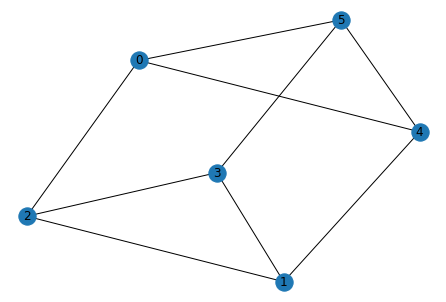

In [19]:
from qiskit_optimization.applications import Maxcut
import networkx as nx
# Make a graph
graph = nx.random_regular_graph(d=3, n=6, seed=123)
pos = nx.spring_layout(graph, seed=123)
# Make a Max-cut problem from the graph
maxcut = Maxcut(graph)
maxcut.draw(pos=pos)

In [20]:
# Make a QuadraticProgram by calling to_quadratic_program()
qp = maxcut.to_quadratic_program()
print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 3 x_0 + 3 x_1 + 3 x_2 + 3 x_3 + 3 x_4 + 3 x_5 + [ - 4 x_0*x_2 - 4 x_0*x_4
      - 4 x_0*x_5 - 4 x_1*x_2 - 4 x_1*x_3 - 4 x_1*x_4 - 4 x_2*x_3 - 4 x_3*x_5
      - 4 x_4*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



Solving it with QAOA

result:
 optimal function value: 7.0
optimal value: [1. 1. 0. 1. 0. 0.]
status: SUCCESS

solution:
 [[2, 4, 5], [0, 1, 3]]

time: 0.06663990020751953


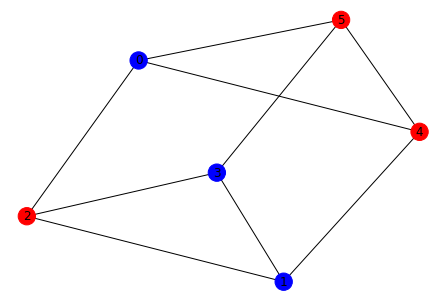

In [21]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver

qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=123)
# Define QAOA solver
meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
result = meo.solve(qp)
print('result:\n', result)
print('\nsolution:\n', maxcut.interpret(result))
print('\ntime:', result.min_eigen_solver_result.optimizer_time)
maxcut.draw(result, pos=pos)

Solving it with Numpy Eigensolver (classical optimizer)

result:
 optimal function value: 7.0
optimal value: [1. 1. 0. 1. 0. 0.]
status: SUCCESS

solution:
 [[2, 4, 5], [0, 1, 3]]


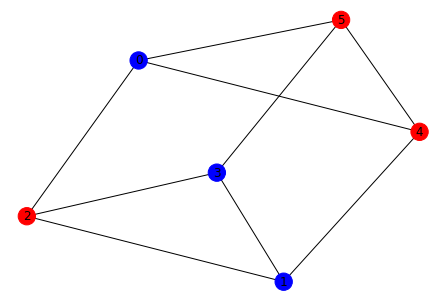

In [9]:
# Numpy Eigensolver
meo = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
result = meo.solve(qp)
print('result:\n', result)
print('\nsolution:\n', maxcut.interpret(result))
maxcut.draw(result, pos=pos)

## Summary
- Optimization problems lie at the core of complex decision-making and definition of strategies.
  - Minimization: cost, weight,... Maximizing: profit, efficiency,...
- Qiskit Optimization covers the whole range of solving optimization problems.
  - High-level modeling of optimization problems.
  - Automatic conversion of problems to required representations (Ising Hamiltonian).
  - Pre-defined application classes to create problems, easily.
  - Allows users to solve problems using a large set of algorithms
    - QAOA, Grover adaptive Search, Classical solvers, ...
- Introduced an example of solving a Max-cut problem
  - using the application class to create a problem
  - solving it with `QAOA` and `NumpyMinimumEigensolver`

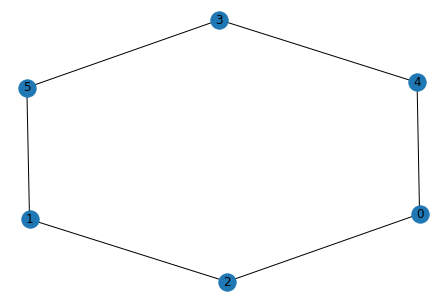

In [10]:
from qiskit_optimization.applications import Maxcut
import networkx as nx
# Make a graph
graph = nx.random_regular_graph(d=2, n=6, seed=123)
pos = nx.spring_layout(graph, seed=123)
# Make a Max-cut problem from the graph
maxcut = Maxcut(graph)
maxcut.draw(pos=pos)

In [11]:
# Make a QuadraticProgram by calling to_quadratic_program()
qp = maxcut.to_quadratic_program()
print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 2 x_0 + 2 x_1 + 2 x_2 + 2 x_3 + 2 x_4 + 2 x_5 + [ - 4 x_0*x_2 - 4 x_0*x_4
      - 4 x_1*x_2 - 4 x_1*x_5 - 4 x_3*x_4 - 4 x_3*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



result:
 optimal function value: 6.0
optimal value: [0. 0. 1. 0. 1. 1.]
status: SUCCESS

solution:
 [[0, 1, 3], [2, 4, 5]]


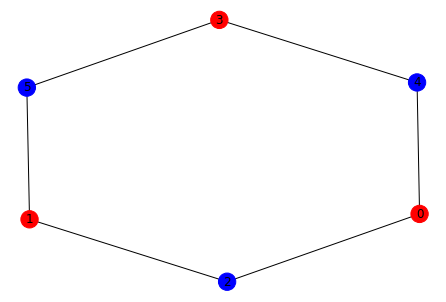

In [12]:
# Numpy Eigensolver
meo = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
result = meo.solve(qp)
print('result:\n', result)
print('\nsolution:\n', maxcut.interpret(result))
maxcut.draw(result, pos=pos)

In [13]:
x = maxcut._result_to_x(result)
x

array([0., 0., 1., 0., 1., 1.])

In [14]:
color = maxcut._node_color(x)

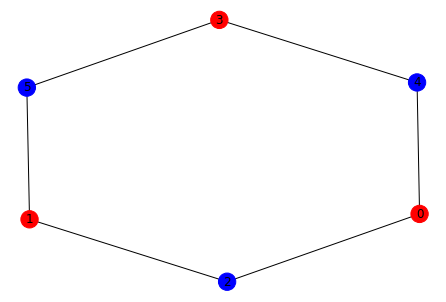

In [15]:
nx.draw(maxcut._graph, node_color=color, pos=pos, with_labels=True)

In [16]:
graph.nodes

NodeView((1, 2, 0, 4, 3, 5))

In [17]:
for i in graph.nodes:
    print(i)

1
2
0
4
3
5


In [18]:
!pip list

Package                       Version   Location
----------------------------- --------- ---------------------------------------------
absl-py                       0.6.1
alabaster                     0.7.12
appdirs                       1.4.4
appnope                       0.1.2
argon2-cffi                   20.1.0
arxiv-latex-cleaner           0.1.21
astroid                       2.5
async-generator               1.10
attrs                         20.3.0
autopep8                      1.5.6
Babel                         2.9.0
backcall                      0.2.0
black                         21.4b2
bleach                        3.3.0
bottle                        0.12.19
certifi                       2020.12.5
cffi                          1.14.5
chardet                       4.0.0
click                         7.1.2
cliff                         3.7.0
cmd2                          1.5.0
colorama                      0.4.4
conan                         1.35.2
coverage                   